### Betthauser, 2024 - Exploring Keras Tuner for Image Classification

In [33]:
import tensorflow as tf
import keras
from pathlib import Path


from keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    BatchNormalization,
    Dropout,
    LeakyReLU,
    MaxPooling2D,
)
from keras.models import Sequential


import keras_tuner as kt
import numpy as np

Load data

In [34]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

Preprocess/normalize data

In [35]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
# X_train = X_train[..., np.newaxis]
# X_test = X_test[..., np.newaxis]
print(X_train.shape)
y_train_1hot = tf.keras.utils.to_categorical(
    y_train, num_classes=len(np.unique(y_train))
)
print(y_train_1hot.shape)

(50000, 32, 32, 3)
(50000, 10)


Build model such that keras-tuner will find best hyperparams (hp)

In [36]:
def build_model(hp):

    loss = "categorical_crossentropy"
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    metrics = ["accuracy"]

    filt_opts0 = [16, 32]
    filt_opts1 = [16, 32, 64]
    filt_opts2 = [32, 64, 128]
    drop_opts = [0.0, 0.1, 0.2, 0.3]
    alpha_opts = [0.0, 0.1, 0.2, 0.3]

    n_layers = 2  # hp.Choice("n_layers", values=[2], default=2)
    n_filt0 = 32  # hp.Choice("n_filt0", values=filt_opts0)
    drop0 = hp.Choice("drop0", values=drop_opts)
    alp0 = hp.Float(
        "alp0", min_value=alpha_opts[0], max_value=alpha_opts[-1]
    )  # hp.Choice("alp0", values=alpha_opts)

    n_filt1 = 64  # hp.Choice("n_filt1", values=filt_opts1)
    drop1 = hp.Choice("drop1", values=drop_opts)
    alp1 = hp.Float(
        "alp1", min_value=alpha_opts[0], max_value=alpha_opts[-1]
    )  # hp.Choice("alp1", values=alpha_opts)

    n_filt2 = 128  # hp.Choice("n_filt2", values=filt_opts2)
    drop2 = hp.Choice("drop2", values=drop_opts)
    alp2 = hp.Float(
        "alp2", min_value=alpha_opts[0], max_value=alpha_opts[-1]
    )  # hp.Choice("alp2", values=alpha_opts)

    # n_dense = hp.Choice("n_dense", values=[16, 32, 64])

    model = Sequential()

    model.add(Conv2D(n_filt0, (3, 3), activation="linear", input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=alp0))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(drop0))

    for i in range(n_layers):
        if i < 1:
            model.add(Conv2D(n_filt1, (3, 3), activation="linear"))
            model.add(LeakyReLU(alpha=alp1))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))
            model.add(Dropout(drop1))
        else:
            model.add(Conv2D(n_filt2, (3, 3), activation="linear"))
            model.add(LeakyReLU(alpha=alp2))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))
            model.add(Dropout(drop2))

    model.add(Flatten())
    # model.add(Dense(n_dense, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

    return model

Train model

In [37]:
tuner = kt.BayesianOptimization(
    # tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    # directory="./results_outputs/fashion_mnist_tuner/",
    # project_name="my_hyperparam_search",
)


tuner.search(X_train, y_train_1hot, epochs=2, validation_split=0.2)

Trial 10 Complete [00h 01m 37s]
val_accuracy: 0.6126999855041504

Best val_accuracy So Far: 0.6126999855041504
Total elapsed time: 00h 15m 33s


Retrieve best model

In [38]:
best_model = tuner.get_best_models()[0]
best_params = tuner.get_best_hyperparameters()[0]

print(best_params.values)

{'drop0': 0.2, 'alp0': 0.013372738463502154, 'drop1': 0.3, 'alp1': 0.17582933053678726, 'drop2': 0.2, 'alp2': 0.09463055664103354}


In [39]:
best_trial = tuner.oracle.get_best_trials()[0]
best_trial.summary()

model_path = "./trained_models/cifar10_cnn_kerastuned.h5"

best_model.save(model_path, overwrite=True)

Trial 09 summary
Hyperparameters:
drop0: 0.2
alp0: 0.013372738463502154
drop1: 0.3
alp1: 0.17582933053678726
drop2: 0.2
alp2: 0.09463055664103354
Score: 0.6126999855041504


c:\Users\jlbetthauser\anaconda3\envs\jlb_dev\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_es_call = keras.callbacks.EarlyStopping(patience=8)

model_chkpt_call = keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
)



# model_tboard_call = keras.callbacks.TensorBoard(log_dir='./logs')



model_callbacks = [model_es_call, model_chkpt_call]  # , model_tboard_call]



best_model = keras.saving.load_model(model_path)



best_model.fit(
    X_train, y_train_1hot, epochs=40, validation_split=0.2, callbacks=model_callbacks
)

Epoch 1/40
1249/1250 [============================>.] - ETA: 0s - loss: 1.2234 - accuracy: 0.5737
Epoch 1: val_loss improved from inf to 1.29960, saving model to ./trained_models\cifar10_cnn_kerastuned.h5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.2232 - accuracy: 0.5738 - val_loss: 1.2996 - val_accuracy: 0.5457
Epoch 2/40
1250/1250 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.6449
Epoch 2: val_loss improved from 1.29960 to 1.00424, saving model to ./trained_models\cifar10_cnn_kerastuned.h5
1250/1250 [==============================] - 42s 33ms/step - loss: 1.0207 - accuracy: 0.6449 - val_loss: 1.0042 - val_accuracy: 0.6505
Epoch 3/40
1250/1250 [==============================] - ETA: 0s - loss: 0.9456 - accuracy: 0.6701
Epoch 3: val_loss did not improve from 1.00424
1250/1250 [==============================] - 42s 34ms/step - loss: 0.9456 - accuracy: 0.6701 - val_loss: 1.3286 - val_accuracy: 0.5509
Epoch 4/40
1250/1250 [==============

Test performance

In [41]:
final_model = keras.saving.load_model(model_path)
y_test_1hot = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_1hot)
y_pred_onehot = final_model.predict(X_test)
y_pred = [np.argmax(row) for row in y_pred_onehot]

print(f"{test_accuracy=:.5f}")

313/313 [==============================] - 3s 10ms/step
test_accuracy=0.77050


Plot some outputs

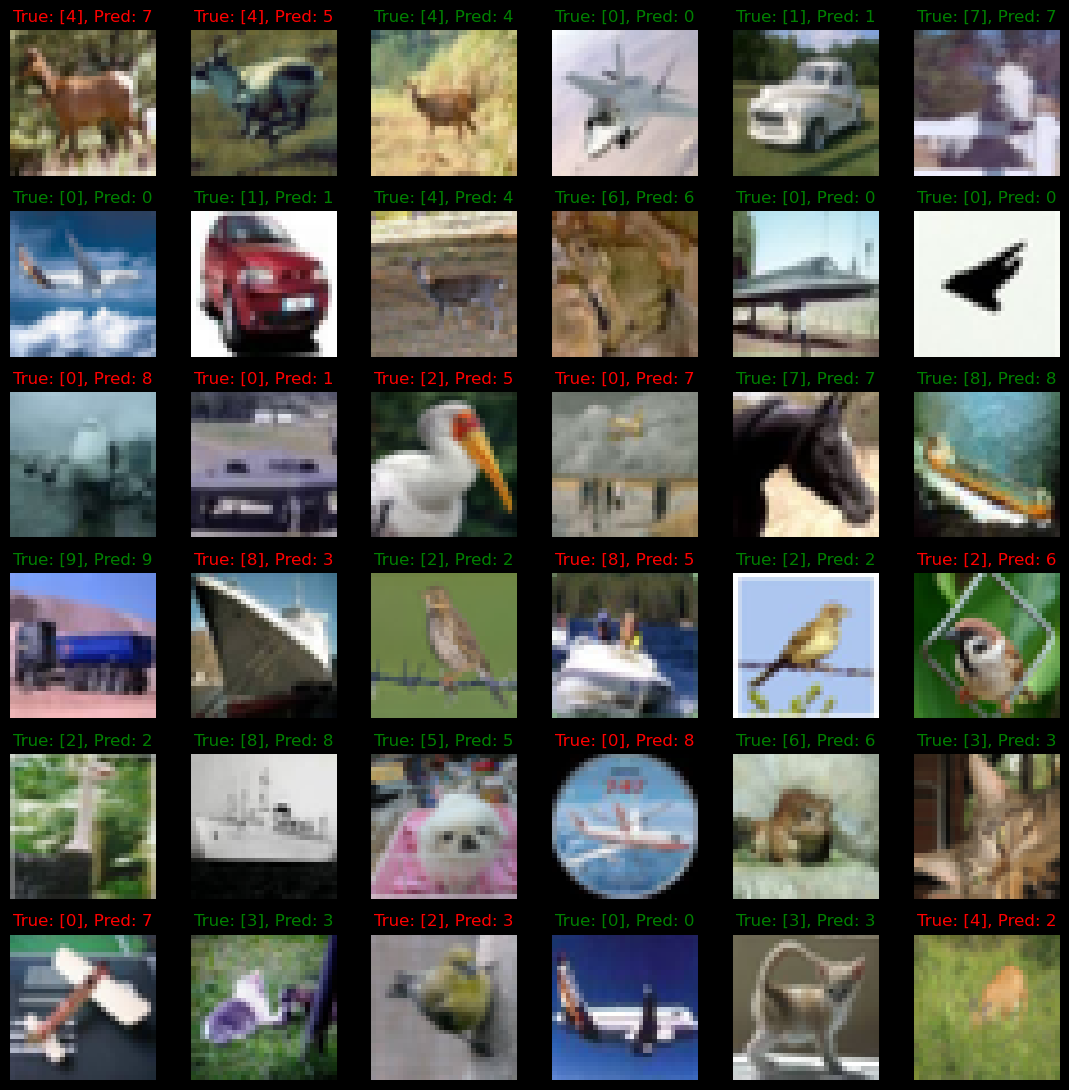

In [44]:
import matplotlib.pyplot as plt

dim = 6
idx = np.random.permutation(len(y_test))

plt.figure(figsize=(11, 11))
for i in range(dim**2):
    img = np.squeeze(X_test[idx[i], ...])
    lbl = y_test[idx[i]]
    prd = y_pred[idx[i]]

    plt.subplot(dim, dim, i + 1)
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.axis("off")
    clr = "Red"
    if lbl == prd:
        clr = "Green"
    plt.title(f"True: {lbl}, Pred: {prd}", color=clr)

plt.tight_layout()

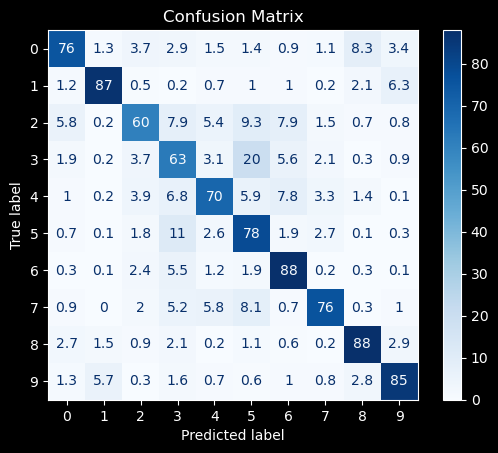

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = 100 * np.round(cm, 3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()